The code implements a deep autoencoder with greedy layer by layer training.

Once the representation of the input feature is learnt by the autoencoder, I have used Kera's CNN classifier to do a multiclass classification

# **About** **the** **dataset**

The MNIST is a database of handwritten digits as images.
It has a training set of 60000 images, and a test set of 10000 images.
The image data have been size-normalized and centered in a fixed-size.

Each image is a 28*28 pixel grayscale images of handwritten single digits between 0 and 9.


[References: http://yann.lecun.com/exdb/mnist/]


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [ ]:
def sigmoid(vec):
    return 1.0/(1.0+np.exp(-vec))

def sigmoid_derivative(data):
    gz = sigmoid(data)
    return gz * (1-gz)

The autoencoder has 3 encoding layers + 3 decoding layers

The weights are share between the first 3 and the last three to make the learning greedy by layer



```
Layer0    Layer1    Layer2     Layer3      Layer4      Layer5      Layer6       
       W1        W2         W3        W3*         W2*         W1*
  x        a->h      a->h       a->h        a->h        a->h        a = x'

Here, a is the linear function  and h is the logistic activation function
Wi* are the transposes of W, Only 3 weight vector are used in the autoencoder
```


    


# **The Auto Encoder architecture for the experiment below**

The image was drawn using google draw(Available in the Report attested with this assignment)

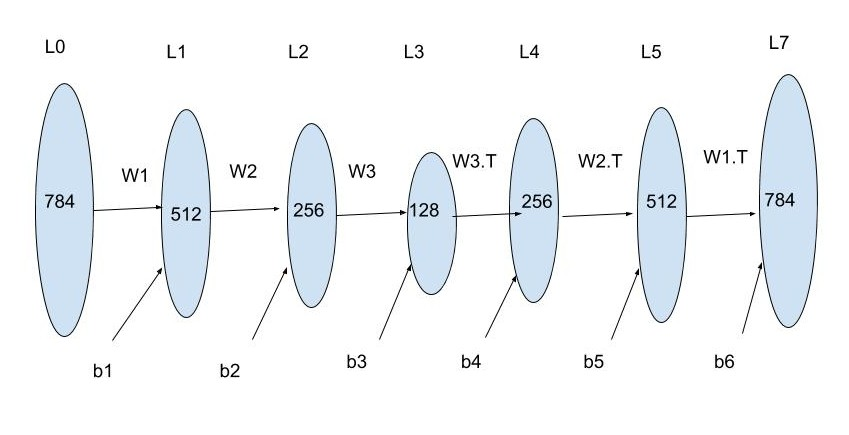

In [ ]:
def forward_pass(X,W1,W2,W3,b1,b2,b3,b4,b5,b6):
    a1 = np.dot(X, W1) + b1    #Layer1 Linear function (preactivation)
    h1 = sigmoid(a1)           #Layer1 Non Linear function (Activation)

    a2 = np.dot(h1, W2) + b2   #Layer2 Linear function (preactivation)
    h2 = sigmoid(a2)           #Layer2 Non Linear function (Activation)

    a3 = np.dot(h2, W3) + b3   #Layer3 Linear function (preactivation)
    h3 = sigmoid(a3)           #Layer3 Non Linear function (Activation)
     
    a4 = np.dot(h3, W3.T) + b4  #Layer4 Linear function (preactivation)
    h4 = sigmoid(a4)            #Layer4 Non Linear function (Activation)

    a5 = np.dot(h4, W2.T) + b5  #Layer5 Linear function (preactivation)
    h5 = sigmoid(a5)            #Layer5 Non Linear function (Activation)

    a6 = np.dot(h5, W1.T)+ b6   #Layer6 Linear function (preactivation)
    return [h1,h2,h3,h4,h5],[a1,a2,a3,a4,a5],a6

In [ ]:
def initialize_weights(nfeatures,nh1,nh2,nh3):
    #Each Weight vector has the input dimension equal to the output dimension of the previous layer
    #And output dimension equal to the input of the next layer
    #Only 3 instead of weights for greedy learning
    W1 = np.random.normal(0, 1, [nfeatures, nh1]) 
    W2 = np.random.normal(0, 1, [nh1,nh2 ]) 
    W3 = np.random.normal(0, 1, [nh2, nh3]) 
    return [W1,W2,W3]

def initialize_biases(nfeatures,nh1,nh2,nh3):
    #Bias for each layer is different
    #Size of bias equal the number of neuron in that layer
    b1 = np.zeros((1, nh1))
    b2 = np.zeros((1, nh2))    
    b3 = np.zeros((1, nh3))
    b4 = np.zeros((1, nh2))
    b5 = np.zeros((1, nh1))
    b6 = np.zeros((1, nfeatures)) 
    return [b1,b2,b3,b4,b5,b6]

Since the training data is very large(60000), gradient descent is run on a minibatch of the training data for epoch runs of the entire data

Note: The backward propagation note could be made compact by running it in a loop by storing the weight updates, I have unrolled the loop into statements as there are 6 layers only. This is done to understand the updates in the gradient wrt to the parameters

```
Stochastic Gradient Descent Algorithms
        for epochs:
            for minibatch in trainingData:
                output = forwardPass(minibatch,parameters)
                gradientUpdates = backPropagation(output,parameters)
                parameters = parameter - learningRate*gradientUpdates - regularization
            findLoss(output)
        return parameters
```



In [ ]:
def minibatch_gradient_descent(training_data,params,batch_size=8,epochs=10,eta=0.01,rlambda=0.01,interval=10):

    nfeatures, nh1, nh2 ,nh3  = params
    W1,W2,W3 = initialize_weights(nfeatures,nh1,nh2,nh3)
    b1,b2,b3,b4,b5,b6 = initialize_biases(nfeatures,nh1,nh2,nh3)
    
    epoch_loss = []
    new_representations = []
    for epch in range(epochs):
        print("---------------------------------------")
        print("--------------epoch {0}-----------------".format(epch))
        print("---------------------------------------")
        batch_loss = []      #store the loss at intervals in each epoch
        for i in range(0,len(training_data)-batch_size,batch_size):
            X = training_data[i:i+batch_size,:].copy()           #Minibatch

            activation,preactivation, predicted = forward_pass(X,W1,W2,W3,b1,b2,b3,b4,b5,b6)
            
            h1,h2,h3,h4,h5 = activation
            a1,a2,a3,a4,a5 = preactivation
            
            gradient_L_wrt_y = (predicted - X) / predicted.shape[0]       #Gradient of loss with respect to the output
    
            #No need to find the gradient wrt W6,W5,W4 and the updates can be obtained from W1,W2,W3 respectively
            #Since bias is different for each layer

            #Begin Backpropagation
            gradient_L_wrt_b6 = np.sum(gradient_L_wrt_y, axis = 0, keepdims = True)  
            
            gradient_L_wrt_h5 = np.dot(gradient_L_wrt_y, W1)                #gradient of Loss wrt to the activation function in hidden layer 5 
            gradient_L_wrt_h5 = gradient_L_wrt_h5 * sigmoid_derivative(a5)  #gradient of Loss wrt to the linear function  in hidden layer 5
            
            gradient_L_wrt_b5 = np.sum(gradient_L_wrt_h5, axis = 0, keepdims = True)  
            
            gradient_L_wrt_h4 = np.dot(gradient_L_wrt_h5, W2)               #gradient of Loss wrt to the activation function in hidden layer 4
            gradient_L_wrt_h4 = gradient_L_wrt_h4 * sigmoid_derivative(a4)  #gradient of Loss wrt to the linear function in hidden layer 4
            
            gradient_L_wrt_b4 = np.sum(gradient_L_wrt_h4, axis = 0, keepdims = True)
            
            gradient_L_wrt_h3 = np.dot(gradient_L_wrt_h4, W3)                #gradient of Loss wrt to the activation function in hidden layer 3
            gradient_L_wrt_h3 = gradient_L_wrt_h3 * sigmoid_derivative(a3)   #gradient of Loss wrt to the linear function in hidden layer 3
            
            gradient_L_wrt_W3 = np.dot(h2.T, gradient_L_wrt_h3)               #gradient wrt the weights given to  layer 3
            gradient_L_wrt_b3 = np.sum(gradient_L_wrt_h3, axis = 0, keepdims = True) 
            
            gradient_L_wrt_h2 = np.dot(gradient_L_wrt_h3, W3.T)             #gradient of Loss wrt to the activation function in hidden layer 2
            gradient_L_wrt_h2 = gradient_L_wrt_h2 * sigmoid_derivative(a2)  #gradient of Loss wrt to the linear function in hidden layer 2 
    
            gradient_L_wrt_W2 = np.dot(h1.T,gradient_L_wrt_h2)               #gradient wrt the weights given to  layer 2
            gradient_L_wrt_b2 = np.sum(gradient_L_wrt_h2, axis = 0, keepdims = True)
            
            gradient_L_wrt_h1 = np.dot(gradient_L_wrt_h2, W2.T)            #gradient of Loss wrt to the activation function in hidden layer 1
            gradient_L_wrt_h1 = gradient_L_wrt_h1 * sigmoid_derivative(a1) #gradient of Loss wrt to the linear function in hidden layer 1  
            
            gradient_L_wrt_W1 = np.dot(X.T, gradient_L_wrt_h1)            #gradient wrt the weights given to  layer 1
            gradient_L_wrt_b1 = np.sum(gradient_L_wrt_h1, axis = 0, keepdims = True)
            #End Backpropagation


            #L2 Norm controlled by hyperparameter rlambda 
            gradient_L_wrt_W3 += rlambda * W3 #this is an exponential sum acts as the momentum
            gradient_L_wrt_W2 += rlambda * W2 #this is an exponential sum acts as the momentum
            gradient_L_wrt_W1 += rlambda * W1 ##this is an exponential sum acts as the momentum
            
            #gradient updates to the network parameters
            W1 = W1 - eta * gradient_L_wrt_W1
            b1 = b1 - eta * gradient_L_wrt_b1

            W2 = W2 - eta * gradient_L_wrt_W2
            b2 = b2 - eta * gradient_L_wrt_b2

            W3 = W3 - eta * gradient_L_wrt_W3
            b3 = b3 - eta * gradient_L_wrt_b3
    
            b4 = b4 - eta * gradient_L_wrt_b4
            b5 = b5 - eta * gradient_L_wrt_b5
            b6 = b6 - eta * gradient_L_wrt_b6
        
            if i % interval == 0:
                #(X-X')^2 in matrix notations is (X-X')T . (X-X')
                error = (predicted - X)
                loss = np.matrix.trace(np.dot(error,error.T))/len(X)
                print('Loss at step {0:4d}: {1:.3f}'.format(i, loss))
                batch_loss.append(loss) 
         
        epoch_loss.append(batch_loss)
        new_representations.append(predicted[0])  #Adding a prediction to see the represention of new image after each epoch
            
    return [W1,W2,W3],[b1,b2,b3,b4,b5,b6],predicted,epoch_loss,new_representations

In [ ]:
from keras.datasets import mnist
(trainx, trainy), (testx, testy) = mnist.load_data()

trainx = np.array(trainx,dtype="float").reshape(60000,784)
trainy = np.array(trainy,dtype="float")
testx = np.array(testx,dtype="float").reshape(10000,784)
testy = np.array(testy,dtype="float")

11493376/11490434 [==============================] - 0s 0us/step


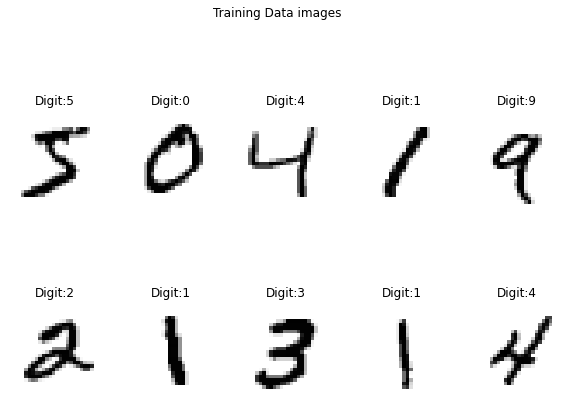

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.suptitle("Training Data images")
for i in range(10):
    ax = plt.subplot(3,5,i+1)
    plt.imshow(trainx[i].reshape(28,28),cmap=cm.binary)
    ax.axis("off")
    ax.set_title("Digit:{0}".format(int(trainy[i])))
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

#Normalizing the training and test data
#Running the above encoder on original data (without normalization) gave large loss in reconstruction

scaler = StandardScaler()
trainx_normalized = scaler.fit_transform(trainx)
test_normalized = scaler.transform(testx)

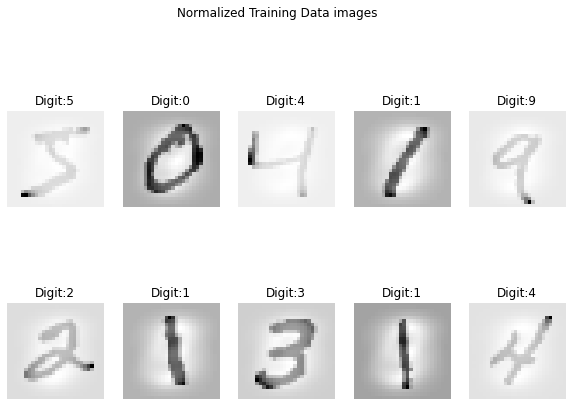

In [ ]:
#plotting the images that are normalized to 0 mean and unit variance

fig = plt.figure(figsize=(10,10))
plt.suptitle("Normalized Training Data images")
for i in range(10):
    ax = plt.subplot(3,5,i+1)
    plt.imshow(trainx_normalized[i].reshape(28,28),cmap=cm.binary)
    ax.axis("off")
    ax.set_title("Digit:{0}".format(int(trainy[i])))
plt.show()

Adding Image of the architecture of the Auto encoder



1.   Running the MNIST data for 10 epochs of the entire data
2.   Minibatch size=8  
3.   Learning Rate =0.01
4.   Regularization parameter = 0.01



In [ ]:
nfeatures = 784  #input layer6
nh1 = 512        #layer1 layer5
nh2 = 256        #layer2 layer4
nh3 = 128        #layer3 
params = [nfeatures, nh1, nh2 ,nh3 ]
epochs=10

weights,biases,predicted,epoch_loss,new_representation = minibatch_gradient_descent(trainx_normalized,params,batch_size=8,epochs=10,eta=0.01,rlambda=0.01,interval=10)

Streaming output truncated to the last 5000 lines.
Loss at step 40360: 459.864
Loss at step 40400: 366.725
Loss at step 40440: 423.307
Loss at step 40480: 328.285
Loss at step 40520: 474.153
Loss at step 40560: 552.369
Loss at step 40600: 516.680
Loss at step 40640: 501.593
Loss at step 40680: 1080.255
Loss at step 40720: 500.284
Loss at step 40760: 393.401
Loss at step 40800: 544.626
Loss at step 40840: 641.669
Loss at step 40880: 229.827
Loss at step 40920: 294.710
Loss at step 40960: 417.111
Loss at step 41000: 281.764
Loss at step 41040: 481.642
Loss at step 41080: 536.250
Loss at step 41120: 402.226
Loss at step 41160: 339.542
Loss at step 41200: 453.250
Loss at step 41240: 657.722
Loss at step 41280: 414.798
Loss at step 41320: 974.039
Loss at step 41360: 2891.053
Loss at step 41400: 1112.174
Loss at step 41440: 274.402
Loss at step 41480: 386.123
Loss at step 41520: 405.630
Loss at step 41560: 397.985
Loss at step 41600: 428.318
Loss at step 41640: 324.619
Loss at step 41680: 24

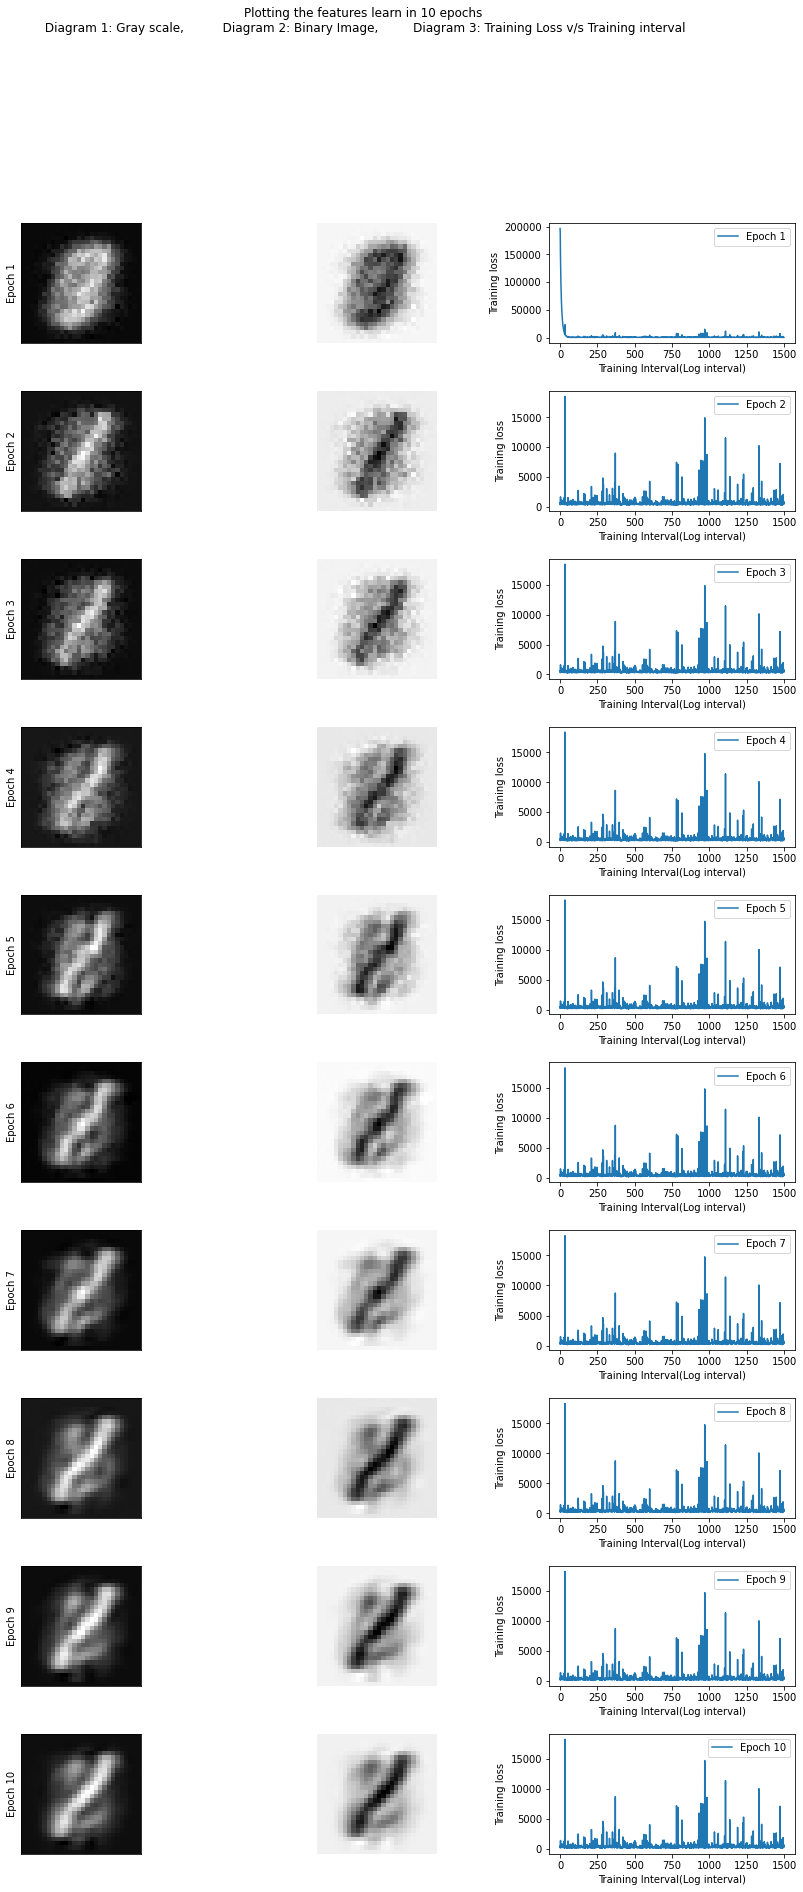

In [ ]:
avg_loss = []
#Mapping the feature maps learnt in each iterations
denormalized_representation = scaler.inverse_transform(new_representation)
fig,axes = plt.subplots(epochs,3,figsize=(15,30))
plt.suptitle("Plotting the features learn in {} epochs\n \
        Diagram 1: Gray scale,  \
        Diagram 2: Binary Image, \
        Diagram 3: Training Loss v/s Training interval\
        ".format(epochs))
plt.subplots_adjust(hspace= 0.4)

#Each epoch plot the denormalized newer representations in gray scale and binary images
for i in range(epochs):
    axes[i][0].imshow(denormalized_representation[i].reshape(28,28),cmap="gray")   
    axes[i][0].set_ylabel("Epoch "+str(i+1))
    axes[i][0].set_xticks([]);axes[i][0].set_yticks([])
    axes[i][1].imshow(denormalized_representation[i].reshape(28,28),cmap=cm.binary)   
    axes[i][1].axis("off") 
    axes[i][2].plot(epoch_loss[i],label="Epoch "+str(i+1))
    axes[i][2].set_xlabel("Training Interval(Log interval)");axes[i][2].set_ylabel("Training loss");
    avg_loss.append(np.mean(epoch_loss[i]))
    axes[i][2].legend()
plt.show()

In [ ]:
print("Loss in the last epoch",epoch_loss[-1])

Loss in the last epoch [492.7527595310935, 205.92927189209348, 484.1644687452556, 1451.1270606329801, 272.299533000404, 282.36849317650865, 512.1100820194403, 706.6299979022076, 865.8111781005827, 439.08357541686655, 463.01315382815255, 265.5004953081826, 912.5974352294747, 530.4105004390877, 702.0590256043006, 687.2724160789755, 715.6023002190841, 289.99514829443444, 389.45149805636515, 378.14877028417015, 275.02640188841565, 306.116035536981, 400.7419399729548, 376.3463797094546, 582.7922493590974, 231.87726698059996, 1304.1227871877256, 760.0307008383859, 774.183852508303, 424.77245981157466, 235.5653053923135, 1767.307759280603, 182.8059258001819, 18299.454511305215, 459.9701204315719, 365.29872633661796, 450.2597715187496, 450.07632807812627, 550.8854744538137, 448.5630974388156, 369.9365754520944, 253.51420124101926, 211.23203996741051, 423.67128101183795, 176.2835525424632, 555.5184745845718, 547.8070871396601, 394.9773517615097, 407.81559291998644, 335.61934471063194, 382.94010

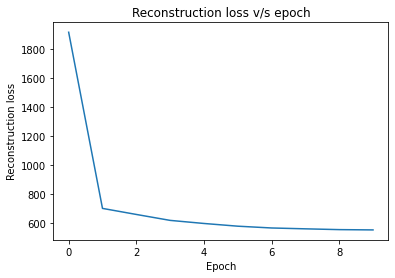

In [ ]:
plt.plot(avg_loss)
plt.title("Reconstruction loss v/s epoch")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction loss")
plt.show()

In [ ]:
W1,W2,W3 = weights
b1,b2,b3,b4,b5,b6 = biases 

#getting the representation from the learnt paramters of the autoencoder

_,_,training_representation = forward_pass(trainx_normalized,W1,W2,W3,b1,b2,b3,b4,b5,b6)

denormalized_representation = scaler.inverse_transform(training_representation)

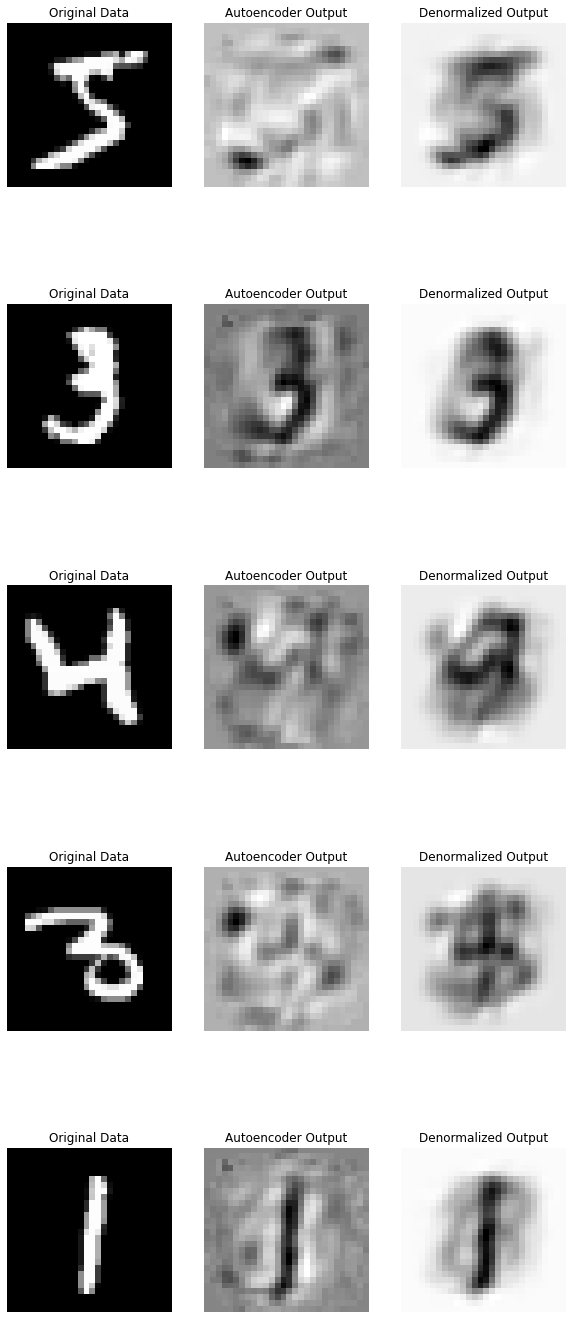

In [ ]:
fig,axes=plt.subplots(5,3,figsize=(10,25))

for i in range(0,5):
    axes[i][0].set_title("Original Data");axes[i][1].set_title("Autoencoder Output"); axes[i][2].set_title("Denormalized Output")
    axes[i][0].imshow(trainx[i*10].reshape(28,28),cmap="gray")
    axes[i][0].axis("off")
    axes[i][1].imshow(training_representation[i*10].reshape(28,28),cmap=cm.binary)
    axes[i][1].axis("off")
    axes[i][2].imshow(denormalized_representation[i*10].reshape(28,28),cmap=cm.binary)
    axes[i][2].axis("off")
plt.show()

In [ ]:
#finding the representation of the test data set based on the parameters of the above encoder

#only forward pass is sufficient to learn the representation of test data(not gradient descent)
_,_,test_representation = forward_pass(test_normalized,W1,W2,W3,b1,b2,b3,b4,b5,b6)

#Squared error loss (X-X')T.(X-X')
error = (test_representation - test_normalized)
testloss = np.matrix.trace(np.dot(error,error.T))/len(test_representation)
print("Reconstruction loss = {:.4f}".format(testloss))

Reconstruction loss = 551.8434


# **Classification of the new representation**

Classification is done using a 3 layer CNN - input layer, dense layer with relu and output layer

Loss function used: Cross entropy


In [ ]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

#fit the training representation/output of the encoder 
model.fit(training_representation, trainy, epochs=10)

#predict the test representation of the encoder test output(this computed in the above cell)
classified_labels = np.argmax(model.predict(test_representation),axis=1)
loss, accuracy = model.evaluate(test_representation,  testy, verbose=2)

print("-------------------\n")
print('Classification of test data gives an accuracy :{:.3f}%'.format(100.0*accuracy))
print("-------------------")

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4112 - accuracy: 0.8806
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1312 - accuracy: 0.9601
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1064 - accuracy: 0.9661
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0921 - accuracy: 0.9710
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0815 - accuracy: 0.9743
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0715 - accuracy: 0.9775
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0655 - accuracy: 0.9784
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0610 - accuracy: 0.9800
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0572 - accuracy: 0.9814
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.051

Plotting the result of the classification on test data

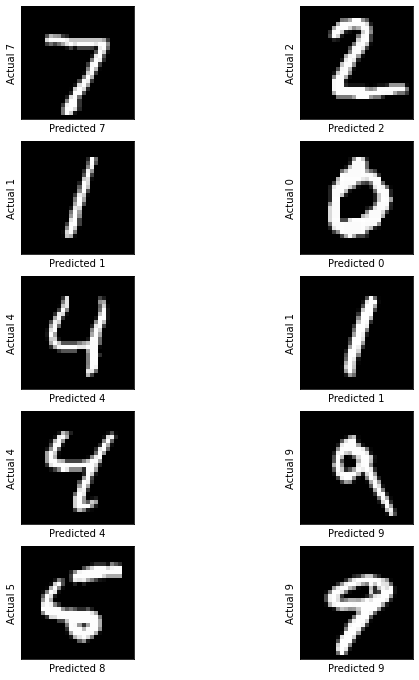

In [ ]:

fig,axes = plt.subplots(5,2,figsize=(10,12))
plt.subplots_adjust(hspace=0.2,wspace=0)

j=0
for i in range(5):
#    print("Classified as {},true class label: {}".format(classified_labels[i],testy[i]))
    axes[i][0].imshow(testx[j].reshape(28,28),cmap="gray")
    axes[i][0].set_xlabel("Predicted "+str(classified_labels[j]))    
    axes[i][0].set_ylabel("Actual "+str(int(testy[j])))
    axes[i][0].set_xticks([]) ,axes[i][0].set_yticks([])     
    
    axes[i][1].imshow(testx[j+1].reshape(28,28),cmap="gray")
    axes[i][1].set_xlabel("Predicted "+str(classified_labels[j+1]))
    axes[i][1].set_ylabel("Actual "+str(int(testy[j+1])))
    axes[i][1].set_xticks([]) ,axes[i][1].set_yticks([])   
    j=j+2
plt.show()